# Training a VAE from CATH Protein Classification Data

To prove the utility of our structural protein feature vectors, we can attempt a classification task in which the model predicts one of three structural protein domains (mostly alpha helices, mostly beta sheets, mixture of alpha helices and beta sheets) based on the input vector. Successful classication indicates our model has adequately learned a condensed representation of a proteins' 3D structure!

First we load our packages.

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline
from cnns4qspr.trainer import Trainer

The CATH data consists of a set of PDBs, each with multiple levels of classification. We are training our VAE on the highest level of classification consisting of only 3 classes (a fourth class exists but was removed due to lack of adequate training data). To save on runtime, the PDBs have already been voxelized and featurized into their respective vectors.

In [2]:
train = np.load('cath_data/train_cath.npy')

In [3]:
print('{} PDBs in training set'.format(train.shape[0]))
print('Single sample has shape 1x{}'.format(train.shape[1]))

11872 PDBs in training set
Single sample has shape 1x257


Each sample in the training set has 256 scalar protein features and 1 label. Let's create our Trainer object and examine some of the default parameters.

In [4]:
vae = Trainer()
print('Training task type = {}'.format(vae.type))
print('Network type = {}'.format(vae.network_type))
print('Num. Input Nodes = {}'.format(vae.architecture['input_size']))
print('Num. Output Nodes = {}'.format(vae.architecture['output_size']))
print('Num. Latent Nodes = {}'.format(vae.architecture['latent_size']))
print('Num. Encoder Hidden Layer Nodes = {}'.format(vae.architecture['encoder'][0]))
print('Num. Decoder Hidden Layer Nodes = {}'.format(vae.architecture['decoder'][0]))
print('Num. Predictor Hidden Layer Nodes = {}, {}'.format(vae.architecture['predictor'][0], vae.architecture['predictor'][1]))

Training task type = classifier
Network type = vae
Num. Input Nodes = 256
Num. Output Nodes = 3
Num. Latent Nodes = 3
Num. Encoder Hidden Layer Nodes = 128
Num. Decoder Hidden Layer Nodes = 128
Num. Predictor Hidden Layer Nodes = 128, 128


By default, a VAE classifier with 256 input nodes, 3 output nodes and a latent size of 3 is constructed. This is built from the VAE class within the cnns4qspr package

In [5]:
print(type(vae.network))

<class 'cnns4qspr.se3cnn_v3.util.arch_blocks.VAE'>


A feedforward network can also be easily built and a regression task may be easily requested. As an example, we can create a fully connected neural network regressor with 3 hidden layers of size 128, 64 and 28 with the following abstracted code:

In [6]:
ffnet = Trainer(type='regressor', network_type='feedforward', predictor=[128,64,28])
print('Training task type = {}'.format(ffnet.type))
print('Network type = {}'.format(ffnet.network_type))
print('Num. Input Nodes = {}'.format(ffnet.architecture['input_size']))
print('Num. Output Nodes = {}'.format(ffnet.architecture['output_size']))
print('Num. Predictor Nodes (Hidden Layer 1) = {}'.format(ffnet.architecture['predictor'][0]))
print('Num. Predictor Nodes (Hidden Layer 2) = {}'.format(ffnet.architecture['predictor'][1]))
print('Num. Predictor Nodes (Hidden Layer 3) = {}'.format(ffnet.architecture['predictor'][2]))
print(type(ffnet.network))

Training task type = regressor
Network type = feedforward
Num. Input Nodes = 256
Num. Output Nodes = 1
Num. Predictor Nodes (Hidden Layer 1) = 128
Num. Predictor Nodes (Hidden Layer 2) = 64
Num. Predictor Nodes (Hidden Layer 3) = 28
<class 'cnns4qspr.se3cnn_v3.util.arch_blocks.FeedForward'>


Notice how the number of output nodes is automatically reduced to 1 for a regressor. If classification is done on a dataset with more or less than 3 labels, the number of output nodes will have to be adjusted manually. Now that we understand the architecture of our neural nets, let's train the VAE on our CATH data.

In [7]:
features = train[:,:-1]
labels = train[:,-1]
vae.train(features, labels, n_epochs=20, batch_size=8)

Data loaded...
Network built...
[1/20] [###################################################] train_loss=1.24 val_loss=1.14 train_acc=0.37 val_acc=0.35
[2/20] [###################################################] train_loss=1.08 val_loss=1.04 train_acc=0.46 val_acc=0.45
[3/20] [###################################################] train_loss=0.98 val_loss=0.93 train_acc=0.52 val_acc=0.56
[4/20] [###################################################] train_loss=0.95 val_loss=0.98 train_acc=0.54 val_acc=0.49
[5/20] [###################################################] train_loss=0.93 val_loss=0.9 train_acc=0.54 val_acc=0.56
[6/20] [###################################################] train_loss=0.92 val_loss=0.88 train_acc=0.55 val_acc=0.58
[7/20] [###################################################] train_loss=0.92 val_loss=0.89 train_acc=0.55 val_acc=0.57
[8/20] [###################################################] train_loss=0.91 val_loss=0.91 train_acc=0.56 val_acc=0.54
[9/20] [#########

By default the Trainer selects the Adam optimizer with a learning rate of 1e-4. It stores both the current state and best state of the model in `Trainer.current_state` and `Trainer.checkpoint` respectively. The criterion for best state defaults to accuracy for a classifier. 

In [8]:
print('Best Validation Accuracy = {}'.format(vae.checkpoint['best_accuracy']))

Best Validation Accuracy = 0.6282266974449158


Current and best states of the model can be saved using `Trainer.save()` and loaded using `Trainer.load('my_best_vae.ckpt')`. Data regarding the run is also stored as attributes of the Trainer object. For instance, accuracy/loss vs. epochs plots can be made by accessing `Trainer.total_losses` and `Trainer.accuracies` attributes.

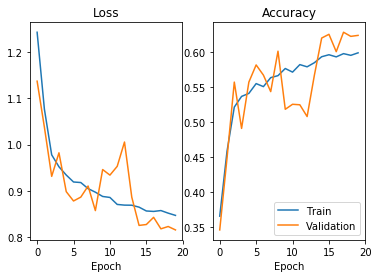

In [9]:
fig, axs = plt.subplots(1,2)
axs[0].plot(vae.total_losses['train'], label='Train')
axs[0].plot(vae.total_losses['validation'], label='Validation')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[1].plot(vae.accuracies['train'], label='Train')
axs[1].plot(vae.accuracies['validation'], label='Validation')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
plt.legend(loc='best')
plt.show()

The VAE is learning how to classify protein domains based on 3D atomic coordinates! We can run PCA on our latent space to see how our latent vector has organized itself.

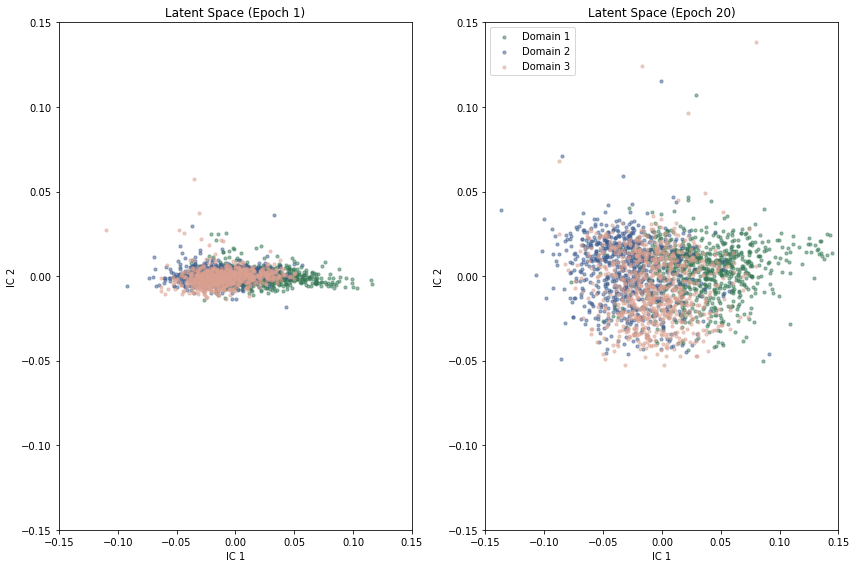

In [19]:
fig, axs = plt.subplots(1,2,figsize=(12,8))
color_palette = ['#377856', '#3F5D8F', '#DAA190']

latent_means = vae.latent_means['validation'][0,:,:]
labels = vae.label_history['validation'][0,:]
pca = PCA(2)
ics = pca.fit_transform(latent_means)
axs[0].scatter(ics[np.where(labels == 0.),0], ics[np.where(labels == 0.),1], c=color_palette[0], s=10, alpha=0.5, label='Domain 1')
axs[0].scatter(ics[np.where(labels == 1.),0], ics[np.where(labels == 1.),1], c=color_palette[1], s=10, alpha=0.5, label='Domain 2')
axs[0].scatter(ics[np.where(labels == 2.),0], ics[np.where(labels == 2.),1], c=color_palette[2], s=10, alpha=0.5, label='Domain 3')
axs[0].set_title('Latent Space (Epoch 1)')
axs[0].set_xlim([-.15,.15])
axs[0].set_ylim([-.15,.15])
axs[0].set_xlabel('IC 1')
axs[0].set_ylabel('IC 2')

latent_means = vae.latent_means['validation'][-1,:,:]
labels = vae.label_history['validation'][-1,:]
pca = PCA(2)
ics = pca.fit_transform(latent_means)
axs[1].scatter(ics[np.where(labels == 0.),0], ics[np.where(labels == 0.),1], c=color_palette[0], s=10, alpha=0.5, label='Domain 1')
axs[1].scatter(ics[np.where(labels == 1.),0], ics[np.where(labels == 1.),1], c=color_palette[1], s=10, alpha=0.5, label='Domain 2')
axs[1].scatter(ics[np.where(labels == 2.),0], ics[np.where(labels == 2.),1], c=color_palette[2], s=10, alpha=0.5, label='Domain 3')
axs[1].set_title('Latent Space (Epoch 20)')
axs[1].set_xlim([-.15,.15])
axs[1].set_ylim([-.15,.15])
axs[1].set_xlabel('IC 1')
axs[1].set_ylabel('IC 2')


plt.legend(loc='best')
fig.tight_layout()
plt.show()

The above figure shows how the VAE has begun to imprint domain classification into its latent space. This illustrates how CNNs may be used to generate dense feature vectors encoded with structural information. In this example we only used alpha carbons, however in addition to more detailed structural channels, 3D chemical information (e.g. hydrophobicity, electric potential) may also be voxelized and used for training in the future.

While this is just an example, we believe this technology may eventually be used for a wide variety of learning tasks including the prediction of structural changes at an atomistic level. 